In [1]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import seaborn as sns
import numpy
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
%matplotlib inline
# import

In [ ]:
raw_data_folder = "raw_data//"
processed_data_folder = "processed_data//"
models_folder = "models//"

In [2]:
train_data = pd.read_csv(processed_data_folder + 'imputed_train.csv')
test_data = pd.read_csv(processed_data_folder + 'imputed_test.csv')


We recheck if we imputed all of the values needed.

In [3]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   891 non-null    int64  
 1   PassengerId  891 non-null    int64  
 2   Survived     891 non-null    int64  
 3   Pclass       891 non-null    int64  
 4   Name         891 non-null    object 
 5   Sex          891 non-null    object 
 6   Age          891 non-null    float64
 7   SibSp        891 non-null    int64  
 8   Parch        891 non-null    int64  
 9   Ticket       891 non-null    object 
 10  Fare         891 non-null    float64
 11  Embarked     891 non-null    object 
 12  Alone        891 non-null    int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 90.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed:

For data with low cardinality, we will use pie charts. Numerical columns, even some of the ones with low cardinality, are better visualised using methods such as histograms.

In [4]:
types = train_data.dtypes
pd.DataFrame([train_data.apply(pd.Series.nunique),types])

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Alone
0,891,891,2,3,891,2,89,7,7,681,248,3,2
1,int64,int64,int64,int64,object,object,float64,int64,int64,object,float64,object,int64


First we will look at the distribution of surivivors.

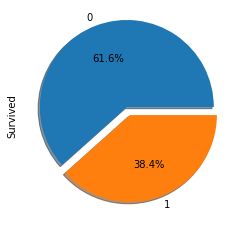

In [5]:
ax = plt.subplot()
explode = [0.1,0]
train_data.Survived.value_counts().plot(kind = 'pie', ax = ax, autopct='%1.1f%%', shadow = True, explode = explode)


# Test - train discrepancy
We should compare the distrution in the test set and the train set to see if the data distributions vary too greatly for some variables. If that is the case, some methods to correct this issue might be needed.

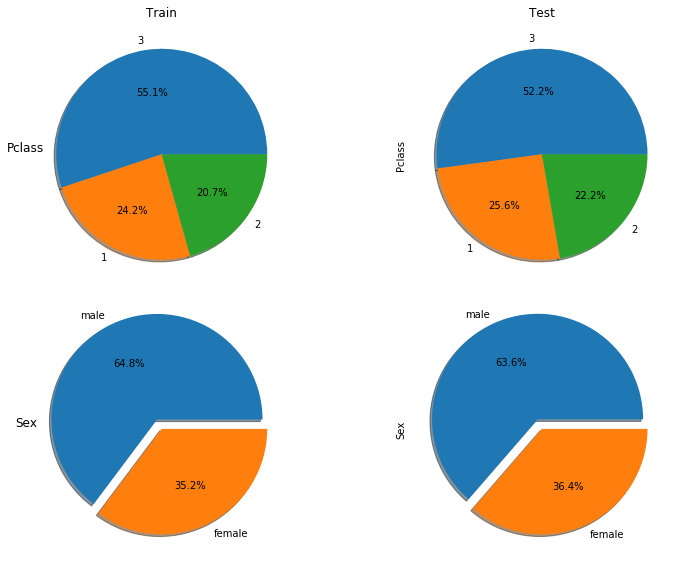

In [6]:

cols = ['{}'.format(col) for col in ['Train',"Test"]]
rows = ['{}'.format(row) for row in ['Pclass', 'Sex']]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))


train_data.Pclass.value_counts().plot(kind = 'pie', ax = axes[0][0], autopct='%1.1f%%', shadow = True, title = "Train")
test_data.Pclass.value_counts().plot(kind = 'pie', ax = axes[0][1], autopct='%1.1f%%', shadow = True, title = "Test")
train_data.Sex.value_counts().plot(kind = 'pie', ax = axes[1][0], autopct='%1.1f%%', shadow = True, explode = explode)
test_data.Sex.value_counts().plot(kind = 'pie', ax = axes[1][1], autopct='%1.1f%%', shadow = True, explode = explode)


for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
fig.tight_layout()
plt.show()

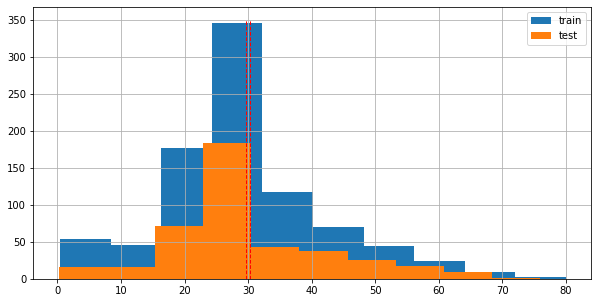

In [7]:
fig, ax = plt.subplots(figsize = (10,5))
train_data.Age.hist(ax =ax , label = "train")
test_data.Age.hist(ax = ax, label = "test")
ax.legend(loc = "upper right")
ax.vlines(x=[train_data.Age.mean(), test_data.Age.mean()],ymin= 0, ymax = 350, color='r', linestyle='dashed', linewidth=1)

### Conclusion:
We can see that the distributions match well enough, so no measure to adjust the training set or oversample is required.
<br>
Now, we can move on to visualising feature importance and correlation

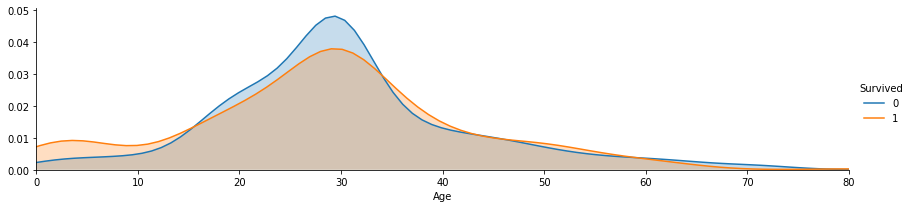

In [8]:
a = sns.FacetGrid( train_data, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , train_data['Age'].max()))
a.add_legend()

To better visualize the distribution of survivors in respect to some features, we add a "died" column, used just for visualisation as to not introduce too much correlation between variables

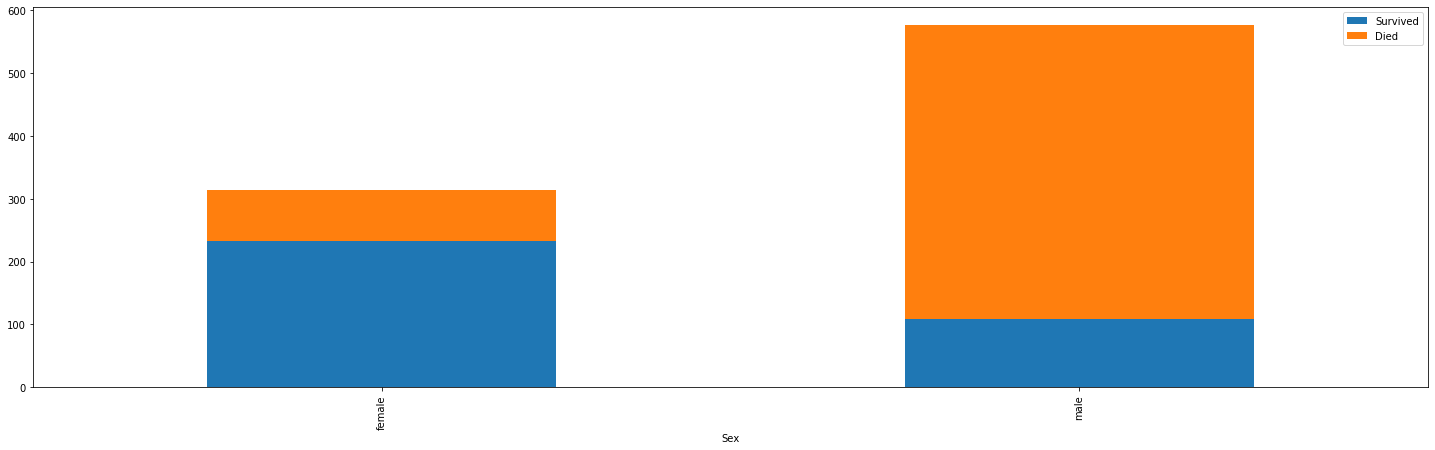

In [9]:
train_data["Died"] = 1 - train_data.Survived
train_data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True);

In [ ]:
transformed = pd.read_csv(processed_data_folder + "transformed_train_ordinal.csv")
transformed

<br>
<br>
We will now analyze the correlations in the dataset, taking into account the transformed variables
<br>
Note that we introduced a highly correlated value when adding the "Alone" columns, because it is strictly based off of siblings and children. However, a binary value in this case may be useful.
<br>
The second highest is unsuprinsingly between Fare and Class, a higher value of Class implying the ticket was less expensive.
<br>
Two interesting correlations can be observed, which are a direct effect of the course of action taken after the disaster:
1. A "woman and children first" policy was followed, explaining the high value in the (Sex,Survived) entry
2. Wealthier people were prioritised this situation: "Third-class passengers were largely left to fend for themselves, causing many of them to become trapped below decks as the ship filled with water." (Quote from the article on wikipedia)

To test the first affirmation, we can plot the survivors in respect to age corelated with sex.

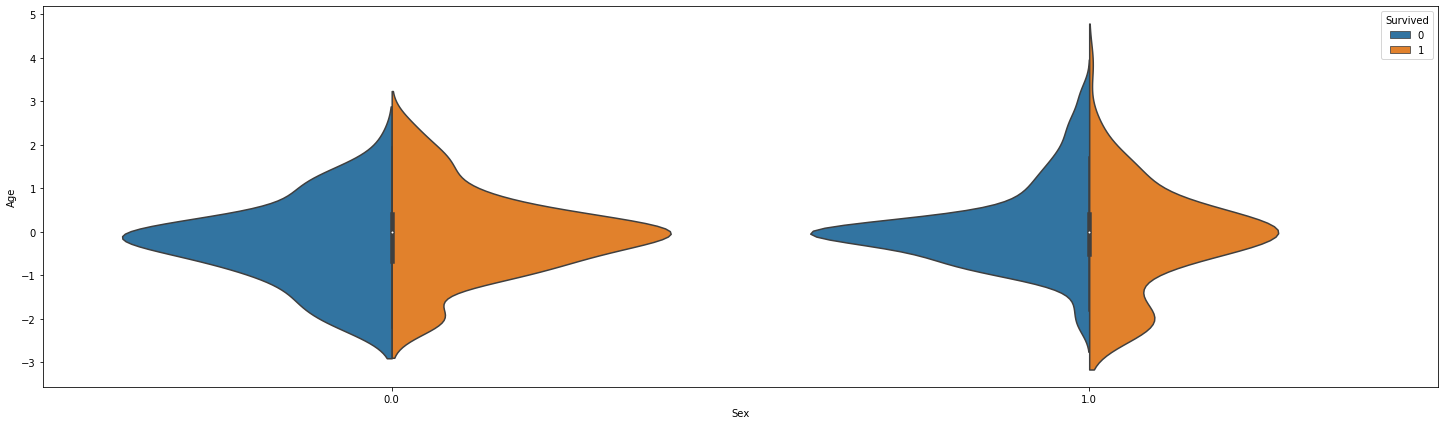

In [31]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=transformed, 
               split=True,
              );

The second affirmation may be visualised with a stacked graph, now focusing on the percentage rather than the raw number, removing the prior probability to have a certain class.

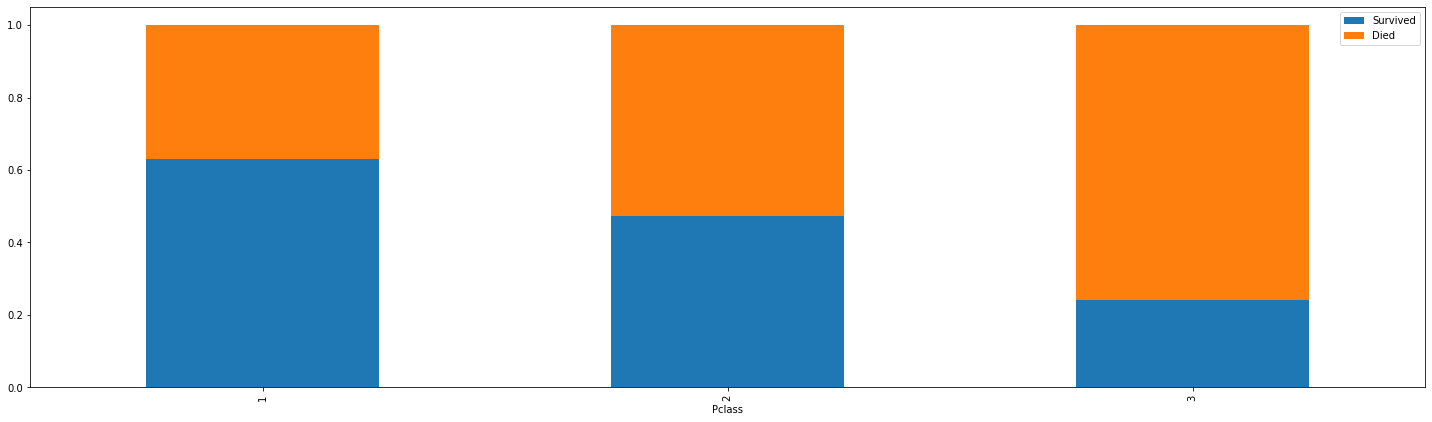

In [33]:
train_data["Died"] = 1 - train_data.Survived
train_data.groupby('Pclass').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True);

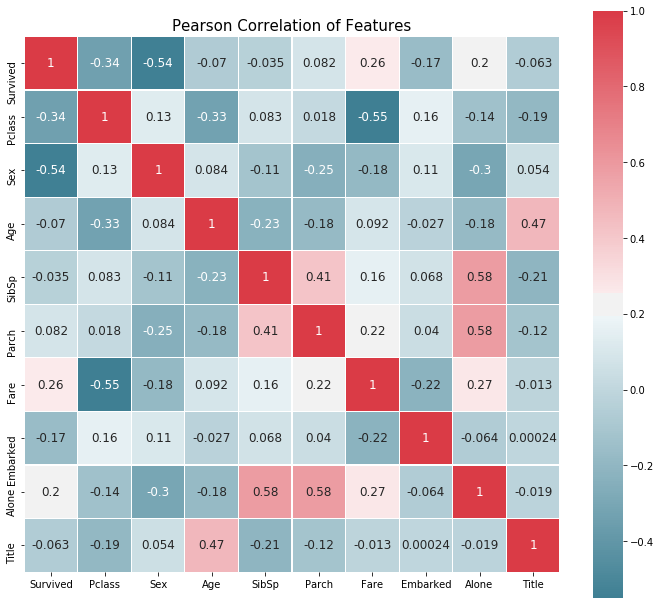

In [34]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(12, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(transformed)


To further visualise the feature importance, we can fit a tree model such as xgboost, most models having built-in functions for this endeavor. For this, we will also need to use the standardized dataset. We can also compare the difference in feature importance between the two encodings.

In [41]:
def get_feature_importance(X,Y):
    xgb = XGBClassifier()
    xgb.fit(X,Y)
    importances = pd.Series(xgb.feature_importances_, index = X.columns)
    return importances
standardized_ordinal = pd.read_csv(processed_data_folder + "standardized_train_ordinal.csv")
standardized_onehot = pd.read_csv(processed_data_folder + "standardized_train_onehot.csv")

In [42]:
from preprocessing import split_train
ordinal_split = split_train(standardized_ordinal,0)
onehot_split = split_train(standardized_onehot,0)

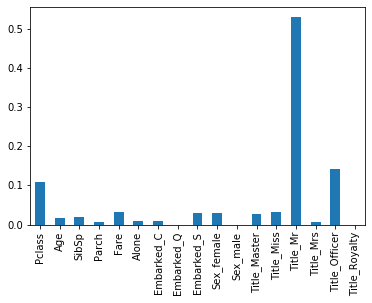

In [43]:
onehot_importances = get_feature_importance(onehot_split[0],onehot_split[2])
onehot_importances.plot(kind = 'bar')

In [44]:
ordinal_importances = get_feature_importance(ordinal_split[0],onehot_split[2])

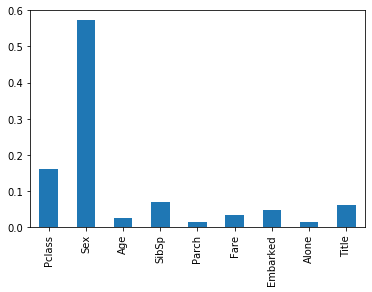

In [45]:
ordinal_importances.plot(kind="bar")

From this visualization we can conclude that while sex is certainly the most important deciding factor by a long shot(expressed by Sex in the ordinal encoding and the "Mr" title in the onehot), the two encoding tend to give very large differences in feature importance. Because of this, we should train the models separately for these 2 cases and see which tends to do better on a validation set to decide what is our prime model/models and their corresponding encoding